# 목표

- 정상적인 사용자와 분산형 크롤러를 구분 가능한지 확인한다.


# 순서

1. 웹 트래픽 데이터를 로드한다.
2. 전반부 N일과 후반부 30-N일을 분리한다.
3. 전반부 N일로 td3 영역을 체크한다. 0회 접근한 아이템 까지 포함한다.
4. 후반부 30-N일 트래픽으로 false positive를 확인한다.
5. 크롤러로 true positive를 확인한다.


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [95]:
import anti_crawler as ac

In [96]:
a = ac.AntiCrawl()

Loading access_log_jul95.csv
Removing failed requests..
Adding day column..
Load Complete 1701011 items


# Get long-tail item data frame

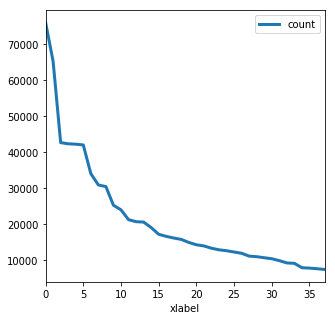

count       38.000000
mean     21250.947368
std      15859.346650
min       7326.000000
25%      10912.750000
50%      15254.000000
75%      24852.750000
max      76040.000000
Name: count, dtype: float64


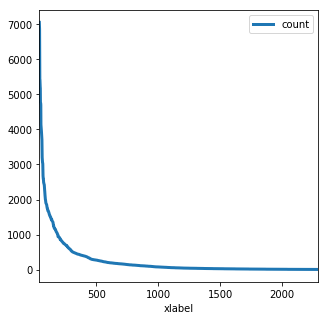

count    2256.000000
mean      264.886082
std       630.802071
min         9.000000
25%        21.000000
50%        53.000000
75%       203.000000
max      7043.000000
Name: count, dtype: float64


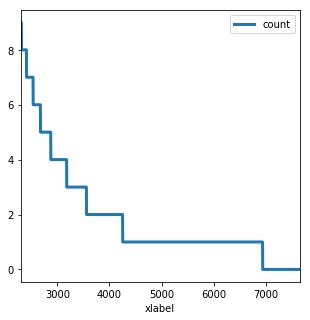

count    5355.000000
mean        1.882353
std         1.860963
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: count, dtype: float64
Count: 5355 / 7649


In [97]:
train_until = 23
td3 = a.get_td3(train_until, _label=[0.005, 0.1, 0.3])

# Simulator Functions
- Crawler Set Node Reducing Simulator
- Web Traffic Node Reducing False Positive Checker

In [98]:
def simulate(crawl_num, df, item_list, threshold, except_item=".gif", _plot=True):
    result = dict()
    attacker_ip = [x for x in range(crawl_num)]
    server_mem = dict()
    
    td3_list = df[df['count'] <= threshold]['uri'].values

    aip = 0
    
    for pos, item in enumerate(item_list):
        laip = len(attacker_ip)
        
        result[pos] = laip
        
        if laip < 1:
            continue
            
        aip = (aip + 1) % laip
        
        if item.lower().endswith(except_item):
            continue
            
        if item not in td3_list:
            continue
            
        atkip = attacker_ip[aip]

        if atkip not in server_mem:
            server_mem[atkip] = [item]
        elif item not in server_mem[atkip]:
            server_mem[atkip].append(item)

        if len(server_mem[atkip]) >  threshold:
            attacker_ip.remove(atkip)       
    
    if _plot:
        df_result = pd.DataFrame.from_dict(result, orient='index')
        ax = df_result.plot()
        ax.legend(["number of nodes"])
        plt.show()
    
    return laip


def simulate_real(df_traffic, df_td3, threshold, except_item=".gif", _plot=False):
    result = dict()
    server_mem = dict()
    banned = list()
    server_mem = dict()
    
    td3_list = df_td3[df_td3['count'] <= threshold]['uri'].values
    n = 0
    
    for item in df_traffic.iterrows():
        uri = str(item[1].URI)
        ip = item[1].IP
        
        result[n] = len(banned)
        n += 1
        
        if ip in banned:
            continue
            
        if uri.lower().endswith(except_item):
            continue
        
        if uri not in td3_list:
            continue
            
        if ip not in server_mem:
            server_mem[ip] = [uri]
        elif uri not in server_mem[ip]:
            server_mem[ip].append(uri)
        
        if len(server_mem[ip]) > threshold:
            banned.append(ip)
            print(banned)
            
    if _plot:
        df_result = pd.DataFrame.from_dict(result, orient='index')
        df_result.plot()
        plt.show()
    
    return banned, server_mem
        
        

# Simulate Node Reducing

7649
(5355, 5)


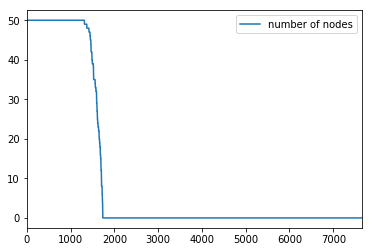

0


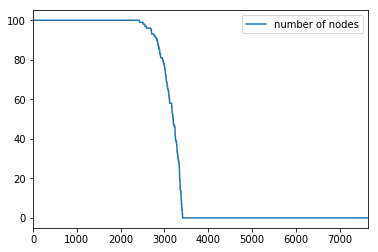

0


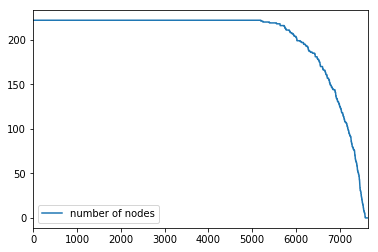

0


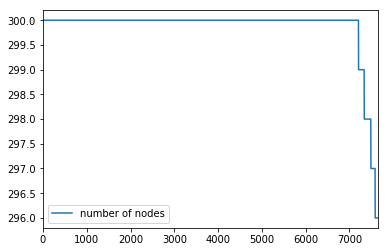

296


In [131]:

threshold = 20
except_item = '.gif'

df_count = a.get_item_count(a.df)

item_list = df_count['uri'].tolist()
random.shuffle(item_list)

print(len(item_list))
print(td3.shape)

result = simulate(50, td3, item_list, threshold, except_item=except_item)
print(result)

result = simulate(100, td3, item_list, threshold, except_item=except_item)
print(result)

result = simulate(222, td3, item_list, threshold, except_item=except_item)
print(result)

result = simulate(300, td3, item_list, threshold, except_item=except_item)
print(result)


# Simulate Web Traffic with Node Reducing Algorithm

In [118]:
gr_traffic = a.df[a.df.day > (train_until - 1)].groupby('day')

In [119]:
banned_list = list()
with open("day_traffic_fp.csv", 'w', encoding='utf-8') as fo:
    fo.write("DAY|NUM_TRFC|NUM_BANNED|NUM_IP|FP_RATE|BANNED_LIST\n")
    for day, df_trf in gr_traffic:  
        banned, serv_mem = simulate_real(df_trf, td3, threshold, except_item=except_item)
        banned_list += banned
        num_banned = len(banned)
        num_traffic = df_trf.shape[0]
        
        day_ip = df_trf['IP'].nunique()
        
        if day_ip == 0:
            continue
        
        wline = "%d|%d|%d|%d|%f|%s\n" % (day, num_traffic, num_banned, day_ip, (num_banned / day_ip), ",".join(banned))
        print(wline)
        
        fo.write(wline)
        print("---------------------------")

23|36125|0|2575|0.000000|

---------------------------
['jbiagioni.npt.nuwc.navy.mil']
['jbiagioni.npt.nuwc.navy.mil', 'dwkm206.usa1.com']
24|58183|2|4223|0.000474|jbiagioni.npt.nuwc.navy.mil,dwkm206.usa1.com

---------------------------
['jbiagioni.npt.nuwc.navy.mil']
['jbiagioni.npt.nuwc.navy.mil', 'sputnix.cas.und.nodak.edu']
25|57102|2|4321|0.000463|jbiagioni.npt.nuwc.navy.mil,sputnix.cas.und.nodak.edu

---------------------------
['156.80.168.122']
['156.80.168.122', '163.205.180.17']
26|53485|2|4224|0.000473|156.80.168.122,163.205.180.17

---------------------------
['163.205.180.17']
['163.205.180.17', 'jalisco.engr.ucdavis.edu']
27|56107|2|4308|0.000464|163.205.180.17,jalisco.engr.ucdavis.edu

---------------------------
28|24810|0|2140|0.000000|

---------------------------


In [120]:
# 전체 차단 IP
banned_list = list(set(banned_list))
banned_list

['sputnix.cas.und.nodak.edu',
 'dwkm206.usa1.com',
 '156.80.168.122',
 '163.205.180.17',
 'jbiagioni.npt.nuwc.navy.mil',
 'jalisco.engr.ucdavis.edu']

In [121]:
df_day_trfc = pd.read_csv("day_traffic_fp.csv", sep='|', encoding='utf-8')
df_day_trfc

,DAY,NUM_TRFC,NUM_BANNED,NUM_IP,FP_RATE,BANNED_LIST
0,23,36125,0,2575,0.000000,NaN
1,24,58183,2,4223,0.000474,"jbiagioni.npt.nuwc.navy.mil,dwkm206.usa1.com"
2,25,57102,2,4321,0.000463,"jbiagioni.npt.nuwc.navy.mil,sputnix.cas.und.no..."
3,26,53485,2,4224,0.000473,"156.80.168.122,163.205.180.17"
4,27,56107,2,4308,0.000464,"163.205.180.17,jalisco.engr.ucdavis.edu"
5,28,24810,0,2140,0.000000,NaN


In [122]:
df_day_trfc.describe()

,DAY,NUM_TRFC,NUM_BANNED,NUM_IP,FP_RATE
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,25.500000,47635.333333,1.333333,3631.833333,0.000312
std,1.870829,13858.877309,1.032796,997.472289,0.000242
min,23.000000,24810.000000,0.000000,2140.000000,0.000000
25%,24.250000,40465.000000,0.500000,2987.000000,0.000116
50%,25.500000,54796.000000,2.000000,4223.500000,0.000463
75%,26.750000,56853.250000,2.000000,4287.000000,0.000471
max,28.000000,58183.000000,2.000000,4321.000000,0.000474


In [123]:
gr_ip = a.df.groupby('IP')

In [124]:
for ip, df_ip in gr_ip:
    if ip not in banned_list:
        continue
    
    print("%s: %d" % (ip, df_ip.shape[0]))

156.80.168.122: 117
163.205.180.17: 564
dwkm206.usa1.com: 167
jalisco.engr.ucdavis.edu: 424
jbiagioni.npt.nuwc.navy.mil: 2124
sputnix.cas.und.nodak.edu: 101


In [125]:
td3['is_td3'] = True
wierd_ip = 'sputnix.cas.und.nodak.edu'
df_tagged = pd.merge(a.df, td3, how='outer', left_on='URI', right_on='uri')[['IP','URI', 'RESULT', 'day', 'is_td3']]
# a.df[(a.df['IP'] == 'jbiagioni.npt.nuwc.navy.mil') & (a.df['day'] > (train_until - 1))]
df_fp_td3 = df_tagged[(df_tagged['IP'] == wierd_ip) & (df_tagged['day'] > (train_until - 1)) & (df_tagged['is_td3'] == True)]
df_fp_all = df_tagged[(df_tagged['IP'] == wierd_ip) & (df_tagged['day'] > (train_until - 1))]

print("%s - td3: %d / all: %d (%f)" % (wierd_ip, df_fp_td3.shape[0], df_fp_all.shape[0], df_fp_td3.shape[0] / df_fp_all.shape[0]))
df_fp_td3

sputnix.cas.und.nodak.edu - td3: 30 / all: 101 (0.297030)


,IP,URI,RESULT,day,is_td3
1556556,sputnix.cas.und.nodak.edu,/history/gemini/gemini-xi/,200.0,25,True
1556568,sputnix.cas.und.nodak.edu,/history/gemini/gemini-x/,200.0,25,True
1557196,sputnix.cas.und.nodak.edu,/history/mercury/ma-7/,200.0,25,True
1557219,sputnix.cas.und.nodak.edu,/history/mercury/mr-4/,200.0,25,True
1560700,sputnix.cas.und.nodak.edu,/history/mercury/ma-8/,200.0,25,True
1560731,sputnix.cas.und.nodak.edu,/history/mercury/ma-9/,200.0,25,True
1563570,sputnix.cas.und.nodak.edu,/history/mercury/mr-3/,200.0,25,True
1563590,sputnix.cas.und.nodak.edu,/history/gemini/gemini-v/,200.0,25,True
1569558,sputnix.cas.und.nodak.edu,/history/gemini/gemini-3/,200.0,25,True
1569580,sputnix.cas.und.nodak.edu,/history/gemini/gemini-vii/,200.0,25,True


In [126]:
df_fp_td3['URI'].nunique()

29

In [132]:
def parse_uri(_uri):
    if _uri.endswith('/'):
        return '/'
    
    file_name = _uri.split('/')[-1]
    
    if '.' not in file_name:
        return 'no_ext'
    
    return file_name.split('?')[0].split('.')[-1]

# a.df['ext'] = a.df['URI'].apply(lambda x: parse_uri(x))
df_all = a.get_item_count(a.df[['URI', 'IP', 'day']])
df_all['ext'] = df_all['uri'].apply(lambda x: parse_uri(x))

df_all

,count,uri,ext
0,90110,/images/NASA-logosmall.gif,gif
1,77077,/images/KSC-logosmall.gif,gif
2,53653,/images/MOSAIC-logosmall.gif,gif
3,53249,/images/USA-logosmall.gif,gif
4,52889,/images/WORLD-logosmall.gif,gif
5,52761,/images/ksclogo-medium.gif,gif
6,38436,/ksc.html,html
7,36897,/shuttle/countdown/,/
8,36202,/images/launch-logo.gif,gif
9,30457,/images/ksclogosmall.gif,gif


# Show percentage of long-tail item

In [134]:
df_tagged = pd.merge(df_all, td3, how='outer', left_on='uri', right_on='uri')[['uri', 'is_td3', 'ext']]
df_tagged = df_tagged.fillna(False)

gr_ext = df_tagged.groupby('ext')

def sort_func(x):
    return x[1].shape[0]

gr_ext = sorted(gr_ext, key=lambda x: sort_func(x), reverse=True)

for ext, df_ext in gr_ext:
    num_true = df_ext[df_ext['is_td3'] == True].shape[0]
    num_false = df_ext[df_ext['is_td3'] == False].shape[0]
    num_total = num_true + num_false
    print("%s: %d / %d (%0.f %%)" % (ext, num_true, num_total, num_true * 100 / num_total))

pl: 2388 / 2476 (96 %)
gif: 441 / 983 (45 %)
/: 458 / 788 (58 %)
html: 267 / 744 (36 %)
txt: 366 / 617 (59 %)
no_ext: 472 / 484 (98 %)
jpg: 98 / 364 (27 %)
GIF: 206 / 333 (62 %)
htm: 91 / 179 (51 %)
gif": 144 / 159 (91 %)
html": 72 / 80 (90 %)
mpg: 17 / 62 (27 %)
GIF": 47 / 48 (98 %)
jpg": 47 / 47 (100 %)
txt": 26 / 26 (100 %)
jpeg: 18 / 23 (78 %)
ksc: 23 / 23 (100 %)
mpg": 19 / 19 (100 %)
JPG: 12 / 18 (67 %)
pdf: 13 / 16 (81 %)
perl: 11 / 15 (73 %)
92: 14 / 14 (100 %)
wav: 5 / 10 (50 %)
91: 9 / 9 (100 %)
93: 9 / 9 (100 %)
bps: 8 / 8 (100 %)
xbm: 0 / 8 (0 %)
90: 7 / 7 (100 %)
bak: 4 / 5 (80 %)
eps: 4 / 5 (80 %)
wav": 4 / 5 (80 %)
xbm": 5 / 5 (100 %)
89: 4 / 4 (100 %)
bmp: 0 / 3 (0 %)
cgi: 3 / 3 (100 %)
htm": 3 / 3 (100 %)
map: 2 / 3 (67 %)
pl": 2 / 3 (67 %)
zip: 3 / 3 (100 %)
WAV: 0 / 2 (0 %)
art: 1 / 2 (50 %)
bash_history: 2 / 2 (100 %)
com: 1 / 2 (50 %)
doc: 2 / 2 (100 %)
good: 2 / 2 (100 %)
jpl: 2 / 2 (100 %)
txt~: 1 / 2 (50 %)
%24%24%24: 1 / 1 (100 %)
2: 1 / 1 (100 %)
bad: 1 / 1 (1